# PTN Template
This notebook serves as a template for single dataset PTN experiments  
It can be run on its own by setting STANDALONE to True (do a find for "STANDALONE" to see where)  
But it is intended to be executed as part of a *papermill.py script. See any of the   
experimentes with a papermill script to get started with that workflow.  

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Required Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "labels_source",
    "labels_target",
    "domains_source",
    "domains_target",
    "num_examples_per_domain_per_label_source",
    "num_examples_per_domain_per_label_target",
    "n_shot",
    "n_way",
    "n_query",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_transforms_source",
    "x_transforms_target",
    "episode_transforms_source",
    "episode_transforms_target",
    "pickle_name",
    "x_net",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "torch_default_dtype"
}

In [3]:


standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.0001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337


standalone_parameters["num_examples_per_domain_per_label_source"]=100
standalone_parameters["num_examples_per_domain_per_label_target"]=100

standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 100

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "target_accuracy"

standalone_parameters["x_transforms_source"] = ["unit_power"]
standalone_parameters["x_transforms_target"] = ["unit_power"]
standalone_parameters["episode_transforms_source"] = []
standalone_parameters["episode_transforms_target"] = []

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"

# uncomment for CORES dataset
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)


standalone_parameters["labels_source"] = ALL_NODES
standalone_parameters["labels_target"] = ALL_NODES

standalone_parameters["domains_source"] = [1]
standalone_parameters["domains_target"] = [2,3,4,5]

standalone_parameters["pickle_name"] = "cores.stratified_ds.2022A.pkl"


# Uncomment these for ORACLE dataset
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )
# standalone_parameters["labels_source"] = ALL_SERIAL_NUMBERS
# standalone_parameters["labels_target"] = ALL_SERIAL_NUMBERS
# standalone_parameters["domains_source"] = [8,20, 38,50]
# standalone_parameters["domains_target"] = [14, 26, 32, 44, 56]
# standalone_parameters["pickle_name"] = "oracle.frame_indexed.stratified_ds.2022A.pkl"
# standalone_parameters["num_examples_per_domain_per_label_source"]=1000
# standalone_parameters["num_examples_per_domain_per_label_target"]=1000

# Uncomment these for Metahan dataset
# standalone_parameters["labels_source"] = list(range(19))
# standalone_parameters["labels_target"] = list(range(19))
# standalone_parameters["domains_source"] = [0]
# standalone_parameters["domains_target"] = [1]
# standalone_parameters["pickle_name"] = "metehan.stratified_ds.2022A.pkl"
# standalone_parameters["n_way"]  = len(standalone_parameters["labels_source"])
# standalone_parameters["num_examples_per_domain_per_label_source"]=200
# standalone_parameters["num_examples_per_domain_per_label_target"]=100


standalone_parameters["n_way"]  = len(standalone_parameters["labels_source"])

In [4]:
# Parameters
parameters = {
    "experiment_name": "tuned_1v2:wisig",
    "device": "cuda",
    "lr": 0.0001,
    "labels_source": [
        "1-10",
        "1-12",
        "1-14",
        "1-16",
        "1-18",
        "1-19",
        "1-8",
        "10-11",
        "10-17",
        "10-4",
        "10-7",
        "11-1",
        "11-10",
        "11-19",
        "11-20",
        "11-4",
        "11-7",
        "12-19",
        "12-20",
        "12-7",
        "13-14",
        "13-18",
        "13-19",
        "13-20",
        "13-3",
        "13-7",
        "14-10",
        "14-11",
        "14-12",
        "14-13",
        "14-14",
        "14-19",
        "14-20",
        "14-7",
        "14-8",
        "14-9",
        "15-1",
        "15-19",
        "15-6",
        "16-1",
        "16-16",
        "16-19",
        "16-20",
        "17-10",
        "17-11",
        "18-1",
        "18-10",
        "18-11",
        "18-12",
        "18-13",
        "18-14",
        "18-15",
        "18-16",
        "18-17",
        "18-19",
        "18-2",
        "18-20",
        "18-4",
        "18-5",
        "18-7",
        "18-8",
        "18-9",
        "19-1",
        "19-10",
        "19-11",
        "19-12",
        "19-13",
        "19-14",
        "19-15",
        "19-19",
        "19-2",
        "19-20",
        "19-3",
        "19-4",
        "19-6",
        "19-7",
        "19-8",
        "19-9",
        "2-1",
        "2-13",
        "2-15",
        "2-3",
        "2-4",
        "2-5",
        "2-6",
        "2-7",
        "2-8",
        "20-1",
        "20-12",
        "20-14",
        "20-15",
        "20-16",
        "20-18",
        "20-19",
        "20-20",
        "20-3",
        "20-4",
        "20-5",
        "20-7",
        "20-8",
        "3-1",
        "3-13",
        "3-18",
        "3-2",
        "3-8",
        "4-1",
        "4-10",
        "4-11",
        "5-1",
        "5-5",
        "6-1",
        "6-15",
        "6-6",
        "7-10",
        "7-11",
        "7-12",
        "7-13",
        "7-14",
        "7-7",
        "7-8",
        "7-9",
        "8-1",
        "8-13",
        "8-14",
        "8-18",
        "8-20",
        "8-3",
        "8-8",
        "9-1",
        "9-7",
    ],
    "labels_target": [
        "1-10",
        "1-12",
        "1-14",
        "1-16",
        "1-18",
        "1-19",
        "1-8",
        "10-11",
        "10-17",
        "10-4",
        "10-7",
        "11-1",
        "11-10",
        "11-19",
        "11-20",
        "11-4",
        "11-7",
        "12-19",
        "12-20",
        "12-7",
        "13-14",
        "13-18",
        "13-19",
        "13-20",
        "13-3",
        "13-7",
        "14-10",
        "14-11",
        "14-12",
        "14-13",
        "14-14",
        "14-19",
        "14-20",
        "14-7",
        "14-8",
        "14-9",
        "15-1",
        "15-19",
        "15-6",
        "16-1",
        "16-16",
        "16-19",
        "16-20",
        "17-10",
        "17-11",
        "18-1",
        "18-10",
        "18-11",
        "18-12",
        "18-13",
        "18-14",
        "18-15",
        "18-16",
        "18-17",
        "18-19",
        "18-2",
        "18-20",
        "18-4",
        "18-5",
        "18-7",
        "18-8",
        "18-9",
        "19-1",
        "19-10",
        "19-11",
        "19-12",
        "19-13",
        "19-14",
        "19-15",
        "19-19",
        "19-2",
        "19-20",
        "19-3",
        "19-4",
        "19-6",
        "19-7",
        "19-8",
        "19-9",
        "2-1",
        "2-13",
        "2-15",
        "2-3",
        "2-4",
        "2-5",
        "2-6",
        "2-7",
        "2-8",
        "20-1",
        "20-12",
        "20-14",
        "20-15",
        "20-16",
        "20-18",
        "20-19",
        "20-20",
        "20-3",
        "20-4",
        "20-5",
        "20-7",
        "20-8",
        "3-1",
        "3-13",
        "3-18",
        "3-2",
        "3-8",
        "4-1",
        "4-10",
        "4-11",
        "5-1",
        "5-5",
        "6-1",
        "6-15",
        "6-6",
        "7-10",
        "7-11",
        "7-12",
        "7-13",
        "7-14",
        "7-7",
        "7-8",
        "7-9",
        "8-1",
        "8-13",
        "8-14",
        "8-18",
        "8-20",
        "8-3",
        "8-8",
        "9-1",
        "9-7",
    ],
    "episode_transforms_source": [],
    "episode_transforms_target": [],
    "domains_source": [3],
    "domains_target": [1, 2, 4],
    "num_examples_per_domain_per_label_source": -1,
    "num_examples_per_domain_per_label_target": -1,
    "n_shot": 3,
    "n_way": 130,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "pickle_name": "wisig.node3-19.stratified_ds.2022A.pkl",
    "x_transforms_source": [],
    "x_transforms_target": [],
    "dataset_seed": 1337,
    "seed": 1337,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")



In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
# (This is due to the randomized initial weights)
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
###################################
# Build the dataset
###################################

if p.x_transforms_source == []: x_transform_source = None
else: x_transform_source = get_chained_transform(p.x_transforms_source) 

if p.x_transforms_target == []: x_transform_target = None
else: x_transform_target = get_chained_transform(p.x_transforms_target)

if p.episode_transforms_source == []: episode_transform_source = None
else: raise Exception("episode_transform_source not implemented")

if p.episode_transforms_target == []: episode_transform_target = None
else: raise Exception("episode_transform_target not implemented")


eaf_source = Episodic_Accessor_Factory(
    labels=p.labels_source,
    domains=p.domains_source,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name),
    x_transform_func=x_transform_source,
    example_transform_func=episode_transform_source,
    
)
train_original_source, val_original_source, test_original_source = eaf_source.get_train(), eaf_source.get_val(), eaf_source.get_test()


eaf_target = Episodic_Accessor_Factory(
    labels=p.labels_target,
    domains=p.domains_target,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_target,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name),
    x_transform_func=x_transform_target,
    example_transform_func=episode_transform_target,
)
train_original_target, val_original_target, test_original_target = eaf_target.get_train(), eaf_target.get_val(), eaf_target.get_test()


transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [11]:
# Some quick unit tests on the data
from steves_utils.transforms import get_average_power, get_average_magnitude

q_x, q_y, s_x, s_y, truth = next(iter(train_processed_source))

assert q_x.dtype == eval(p.torch_default_dtype)
assert s_x.dtype == eval(p.torch_default_dtype)

print("Visually inspect these to see if they line up with expected values given the transforms")
print('x_transforms_source', p.x_transforms_source)
print('x_transforms_target', p.x_transforms_target)
print("Average magnitude, source:", get_average_magnitude(q_x[0].numpy()))
print("Average power, source:", get_average_power(q_x[0].numpy()))

q_x, q_y, s_x, s_y, truth = next(iter(train_processed_target))
print("Average magnitude, target:", get_average_magnitude(q_x[0].numpy()))
print("Average power, target:", get_average_power(q_x[0].numpy()))


Visually inspect these to see if they line up with expected values given the transforms
x_transforms_source []
x_transforms_target []
Average magnitude, source: 0.07243775
Average power, source: 0.0063471547


Average magnitude, target: 0.081900135
Average power, target: 0.009168604


In [12]:
###################################
# Build the model
###################################
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=(2,256))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [13]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 45], examples_per_second: 1987.6841, train_label_loss: 4.0432, 


epoch: 1, [batch: 5 / 45], examples_per_second: 3942.8046, train_label_loss: 3.4801, 


epoch: 1, [batch: 9 / 45], examples_per_second: 4039.9125, train_label_loss: 3.1273, 


epoch: 1, [batch: 14 / 45], examples_per_second: 4037.6291, train_label_loss: 2.8792, 


epoch: 1, [batch: 18 / 45], examples_per_second: 4031.9230, train_label_loss: 2.5601, 


epoch: 1, [batch: 23 / 45], examples_per_second: 3972.9299, train_label_loss: 2.2283, 


epoch: 1, [batch: 27 / 45], examples_per_second: 4036.5016, train_label_loss: 1.9554, 


epoch: 1, [batch: 31 / 45], examples_per_second: 4032.8936, train_label_loss: 1.7752, 


epoch: 1, [batch: 36 / 45], examples_per_second: 4070.6635, train_label_loss: 1.5621, 


epoch: 1, [batch: 40 / 45], examples_per_second: 4132.0108, train_label_loss: 1.4583, 


epoch: 1, source_val_acc_label: 0.8090, target_val_acc_label: 0.7603, source_val_label_loss: 1.2730, target_val_label_loss: 1.5634, 


New best


epoch: 2, [batch: 1 / 45], examples_per_second: 503.8310, train_label_loss: 1.2431, 


epoch: 2, [batch: 5 / 45], examples_per_second: 4014.9278, train_label_loss: 1.0271, 


epoch: 2, [batch: 9 / 45], examples_per_second: 4113.3361, train_label_loss: 1.1404, 


epoch: 2, [batch: 14 / 45], examples_per_second: 4121.0806, train_label_loss: 1.0086, 


epoch: 2, [batch: 18 / 45], examples_per_second: 4117.8078, train_label_loss: 0.7872, 


epoch: 2, [batch: 23 / 45], examples_per_second: 4038.5621, train_label_loss: 1.0573, 


epoch: 2, [batch: 27 / 45], examples_per_second: 4120.2893, train_label_loss: 1.0713, 


epoch: 2, [batch: 31 / 45], examples_per_second: 4117.2808, train_label_loss: 0.7112, 


epoch: 2, [batch: 36 / 45], examples_per_second: 4159.1420, train_label_loss: 0.7243, 


epoch: 2, [batch: 40 / 45], examples_per_second: 4214.2390, train_label_loss: 0.9454, 


epoch: 2, source_val_acc_label: 0.8750, target_val_acc_label: 0.7991, source_val_label_loss: 0.7090, target_val_label_loss: 1.1198, 


New best


epoch: 3, [batch: 1 / 45], examples_per_second: 497.6757, train_label_loss: 0.8542, 


epoch: 3, [batch: 5 / 45], examples_per_second: 4022.8308, train_label_loss: 0.7413, 


epoch: 3, [batch: 9 / 45], examples_per_second: 4125.3722, train_label_loss: 0.5586, 


epoch: 3, [batch: 14 / 45], examples_per_second: 4114.9811, train_label_loss: 0.8599, 


epoch: 3, [batch: 18 / 45], examples_per_second: 4125.2536, train_label_loss: 0.5030, 


epoch: 3, [batch: 23 / 45], examples_per_second: 4048.0078, train_label_loss: 0.4952, 


epoch: 3, [batch: 27 / 45], examples_per_second: 4123.0700, train_label_loss: 0.5954, 


epoch: 3, [batch: 31 / 45], examples_per_second: 4117.7503, train_label_loss: 0.6897, 


epoch: 3, [batch: 36 / 45], examples_per_second: 4165.1441, train_label_loss: 0.6995, 


epoch: 3, [batch: 40 / 45], examples_per_second: 4210.2755, train_label_loss: 0.6047, 


epoch: 3, source_val_acc_label: 0.9083, target_val_acc_label: 0.8239, source_val_label_loss: 0.5331, target_val_label_loss: 0.9727, 


New best


epoch: 4, [batch: 1 / 45], examples_per_second: 499.8333, train_label_loss: 0.6848, 


epoch: 4, [batch: 5 / 45], examples_per_second: 4007.3812, train_label_loss: 0.6182, 


epoch: 4, [batch: 9 / 45], examples_per_second: 4102.3359, train_label_loss: 0.6506, 


epoch: 4, [batch: 14 / 45], examples_per_second: 4107.9288, train_label_loss: 0.6395, 


epoch: 4, [batch: 18 / 45], examples_per_second: 4106.5069, train_label_loss: 0.4991, 


epoch: 4, [batch: 23 / 45], examples_per_second: 4026.8669, train_label_loss: 0.4166, 


epoch: 4, [batch: 27 / 45], examples_per_second: 4108.5739, train_label_loss: 0.4878, 


epoch: 4, [batch: 31 / 45], examples_per_second: 4110.1379, train_label_loss: 0.3047, 


epoch: 4, [batch: 36 / 45], examples_per_second: 4148.0766, train_label_loss: 0.5042, 


epoch: 4, [batch: 40 / 45], examples_per_second: 4205.0284, train_label_loss: 0.3723, 


epoch: 4, source_val_acc_label: 0.9186, target_val_acc_label: 0.8419, source_val_label_loss: 0.4497, target_val_label_loss: 0.8856, 


New best


epoch: 5, [batch: 1 / 45], examples_per_second: 497.8918, train_label_loss: 0.4738, 


epoch: 5, [batch: 5 / 45], examples_per_second: 4014.6115, train_label_loss: 0.4978, 


epoch: 5, [batch: 9 / 45], examples_per_second: 4106.4048, train_label_loss: 0.3748, 


epoch: 5, [batch: 14 / 45], examples_per_second: 4114.0447, train_label_loss: 0.6448, 


epoch: 5, [batch: 18 / 45], examples_per_second: 4119.9298, train_label_loss: 0.5381, 


epoch: 5, [batch: 23 / 45], examples_per_second: 4045.1884, train_label_loss: 0.5514, 


epoch: 5, [batch: 27 / 45], examples_per_second: 4114.0717, train_label_loss: 0.4394, 


epoch: 5, [batch: 31 / 45], examples_per_second: 4121.5943, train_label_loss: 0.6202, 


epoch: 5, [batch: 36 / 45], examples_per_second: 4151.3560, train_label_loss: 0.3682, 


epoch: 5, [batch: 40 / 45], examples_per_second: 4207.8338, train_label_loss: 0.4124, 


epoch: 5, source_val_acc_label: 0.9346, target_val_acc_label: 0.8553, source_val_label_loss: 0.3969, target_val_label_loss: 0.8316, 


New best


epoch: 6, [batch: 1 / 45], examples_per_second: 497.8549, train_label_loss: 0.2424, 


epoch: 6, [batch: 5 / 45], examples_per_second: 4008.5936, train_label_loss: 0.3242, 


epoch: 6, [batch: 9 / 45], examples_per_second: 4107.3421, train_label_loss: 0.2404, 


epoch: 6, [batch: 14 / 45], examples_per_second: 4101.8224, train_label_loss: 0.3176, 


epoch: 6, [batch: 18 / 45], examples_per_second: 4122.2970, train_label_loss: 0.2572, 


epoch: 6, [batch: 23 / 45], examples_per_second: 4040.9314, train_label_loss: 0.4218, 


epoch: 6, [batch: 27 / 45], examples_per_second: 4116.0577, train_label_loss: 0.3803, 


epoch: 6, [batch: 31 / 45], examples_per_second: 4116.3125, train_label_loss: 0.4030, 


epoch: 6, [batch: 36 / 45], examples_per_second: 4158.9808, train_label_loss: 0.2016, 


epoch: 6, [batch: 40 / 45], examples_per_second: 4209.5539, train_label_loss: 0.2859, 


epoch: 6, source_val_acc_label: 0.9481, target_val_acc_label: 0.8624, source_val_label_loss: 0.3582, target_val_label_loss: 0.8219, 


New best


epoch: 7, [batch: 1 / 45], examples_per_second: 497.3260, train_label_loss: 0.5271, 


epoch: 7, [batch: 5 / 45], examples_per_second: 4008.8824, train_label_loss: 0.3183, 


epoch: 7, [batch: 9 / 45], examples_per_second: 4104.3956, train_label_loss: 0.3685, 


epoch: 7, [batch: 14 / 45], examples_per_second: 4106.6430, train_label_loss: 0.2723, 


epoch: 7, [batch: 18 / 45], examples_per_second: 4103.0336, train_label_loss: 0.2852, 


epoch: 7, [batch: 23 / 45], examples_per_second: 4030.7498, train_label_loss: 0.4531, 


epoch: 7, [batch: 27 / 45], examples_per_second: 4105.1852, train_label_loss: 0.3265, 


epoch: 7, [batch: 31 / 45], examples_per_second: 4108.2241, train_label_loss: 0.3772, 


epoch: 7, [batch: 36 / 45], examples_per_second: 4145.7881, train_label_loss: 0.2004, 


epoch: 7, [batch: 40 / 45], examples_per_second: 4207.6455, train_label_loss: 0.4974, 


epoch: 7, source_val_acc_label: 0.9506, target_val_acc_label: 0.8697, source_val_label_loss: 0.3195, target_val_label_loss: 0.7548, 


New best


epoch: 8, [batch: 1 / 45], examples_per_second: 495.5200, train_label_loss: 0.3866, 


epoch: 8, [batch: 5 / 45], examples_per_second: 4010.7873, train_label_loss: 0.2257, 


epoch: 8, [batch: 9 / 45], examples_per_second: 4115.5917, train_label_loss: 0.4134, 


epoch: 8, [batch: 14 / 45], examples_per_second: 4126.8822, train_label_loss: 0.2755, 


epoch: 8, [batch: 18 / 45], examples_per_second: 4112.8506, train_label_loss: 0.3658, 


epoch: 8, [batch: 23 / 45], examples_per_second: 4039.1389, train_label_loss: 0.3171, 


epoch: 8, [batch: 27 / 45], examples_per_second: 4113.3998, train_label_loss: 0.2559, 


epoch: 8, [batch: 31 / 45], examples_per_second: 4116.0608, train_label_loss: 0.3190, 


epoch: 8, [batch: 36 / 45], examples_per_second: 4144.0564, train_label_loss: 0.2238, 


epoch: 8, [batch: 40 / 45], examples_per_second: 4204.9182, train_label_loss: 0.4240, 


epoch: 8, source_val_acc_label: 0.9577, target_val_acc_label: 0.8699, source_val_label_loss: 0.2934, target_val_label_loss: 0.7538, 


New best


epoch: 9, [batch: 1 / 45], examples_per_second: 495.3183, train_label_loss: 0.3050, 


epoch: 9, [batch: 5 / 45], examples_per_second: 4013.1474, train_label_loss: 0.2968, 


epoch: 9, [batch: 9 / 45], examples_per_second: 4115.4100, train_label_loss: 0.2314, 


epoch: 9, [batch: 14 / 45], examples_per_second: 4118.0504, train_label_loss: 0.3090, 


epoch: 9, [batch: 18 / 45], examples_per_second: 4112.3233, train_label_loss: 0.3863, 


epoch: 9, [batch: 23 / 45], examples_per_second: 4042.7602, train_label_loss: 0.2360, 


epoch: 9, [batch: 27 / 45], examples_per_second: 4117.6306, train_label_loss: 0.1423, 


epoch: 9, [batch: 31 / 45], examples_per_second: 4119.7803, train_label_loss: 0.3239, 


epoch: 9, [batch: 36 / 45], examples_per_second: 4145.8398, train_label_loss: 0.1793, 


epoch: 9, [batch: 40 / 45], examples_per_second: 4208.3307, train_label_loss: 0.1326, 


epoch: 9, source_val_acc_label: 0.9590, target_val_acc_label: 0.8729, source_val_label_loss: 0.2795, target_val_label_loss: 0.7307, 


New best


epoch: 10, [batch: 1 / 45], examples_per_second: 497.4278, train_label_loss: 0.4212, 


epoch: 10, [batch: 5 / 45], examples_per_second: 4015.6316, train_label_loss: 0.1928, 


epoch: 10, [batch: 9 / 45], examples_per_second: 4121.1364, train_label_loss: 0.3777, 


epoch: 10, [batch: 14 / 45], examples_per_second: 4122.2820, train_label_loss: 0.2131, 


epoch: 10, [batch: 18 / 45], examples_per_second: 4118.0410, train_label_loss: 0.2108, 


epoch: 10, [batch: 23 / 45], examples_per_second: 4035.4692, train_label_loss: 0.2389, 


epoch: 10, [batch: 27 / 45], examples_per_second: 4121.1738, train_label_loss: 0.2611, 


epoch: 10, [batch: 31 / 45], examples_per_second: 4124.5655, train_label_loss: 0.1559, 


epoch: 10, [batch: 36 / 45], examples_per_second: 4150.2665, train_label_loss: 0.2384, 


epoch: 10, [batch: 40 / 45], examples_per_second: 4201.5306, train_label_loss: 0.2158, 


epoch: 10, source_val_acc_label: 0.9609, target_val_acc_label: 0.8825, source_val_label_loss: 0.2556, target_val_label_loss: 0.6960, 


New best


epoch: 11, [batch: 1 / 45], examples_per_second: 497.1905, train_label_loss: 0.2775, 


epoch: 11, [batch: 5 / 45], examples_per_second: 4000.0214, train_label_loss: 0.2024, 


epoch: 11, [batch: 9 / 45], examples_per_second: 4089.7680, train_label_loss: 0.2445, 


epoch: 11, [batch: 14 / 45], examples_per_second: 4093.6125, train_label_loss: 0.1461, 


epoch: 11, [batch: 18 / 45], examples_per_second: 4087.8884, train_label_loss: 0.2508, 


epoch: 11, [batch: 23 / 45], examples_per_second: 4030.7319, train_label_loss: 0.2041, 


epoch: 11, [batch: 27 / 45], examples_per_second: 4098.0056, train_label_loss: 0.1565, 


epoch: 11, [batch: 31 / 45], examples_per_second: 4109.1591, train_label_loss: 0.3117, 


epoch: 11, [batch: 36 / 45], examples_per_second: 4141.2124, train_label_loss: 0.1878, 


epoch: 11, [batch: 40 / 45], examples_per_second: 4201.7702, train_label_loss: 0.3121, 


epoch: 11, source_val_acc_label: 0.9622, target_val_acc_label: 0.8825, source_val_label_loss: 0.2464, target_val_label_loss: 0.6713, 


epoch: 12, [batch: 1 / 45], examples_per_second: 506.2374, train_label_loss: 0.2212, 


epoch: 12, [batch: 5 / 45], examples_per_second: 4010.0897, train_label_loss: 0.2018, 


epoch: 12, [batch: 9 / 45], examples_per_second: 4102.4131, train_label_loss: 0.3042, 


epoch: 12, [batch: 14 / 45], examples_per_second: 4110.3417, train_label_loss: 0.2541, 


epoch: 12, [batch: 18 / 45], examples_per_second: 4099.8652, train_label_loss: 0.2134, 


epoch: 12, [batch: 23 / 45], examples_per_second: 4031.6058, train_label_loss: 0.3243, 


epoch: 12, [batch: 27 / 45], examples_per_second: 4105.9410, train_label_loss: 0.1768, 


epoch: 12, [batch: 31 / 45], examples_per_second: 4103.7207, train_label_loss: 0.2063, 


epoch: 12, [batch: 36 / 45], examples_per_second: 4143.7162, train_label_loss: 0.1781, 


epoch: 12, [batch: 40 / 45], examples_per_second: 4206.7365, train_label_loss: 0.3272, 


epoch: 12, source_val_acc_label: 0.9660, target_val_acc_label: 0.8878, source_val_label_loss: 0.2344, target_val_label_loss: 0.6425, 


New best


epoch: 13, [batch: 1 / 45], examples_per_second: 493.0264, train_label_loss: 0.2354, 


epoch: 13, [batch: 5 / 45], examples_per_second: 4029.7432, train_label_loss: 0.1690, 


epoch: 13, [batch: 9 / 45], examples_per_second: 4119.2061, train_label_loss: 0.3720, 


epoch: 13, [batch: 14 / 45], examples_per_second: 4120.5363, train_label_loss: 0.2478, 


epoch: 13, [batch: 18 / 45], examples_per_second: 4115.5948, train_label_loss: 0.3426, 


epoch: 13, [batch: 23 / 45], examples_per_second: 4037.0467, train_label_loss: 0.2911, 


epoch: 13, [batch: 27 / 45], examples_per_second: 4119.4317, train_label_loss: 0.4031, 


epoch: 13, [batch: 31 / 45], examples_per_second: 4118.5170, train_label_loss: 0.1608, 


epoch: 13, [batch: 36 / 45], examples_per_second: 4150.4131, train_label_loss: 0.3063, 


epoch: 13, [batch: 40 / 45], examples_per_second: 4211.9814, train_label_loss: 0.1300, 


epoch: 13, source_val_acc_label: 0.9609, target_val_acc_label: 0.8833, source_val_label_loss: 0.2438, target_val_label_loss: 0.7003, 


epoch: 14, [batch: 1 / 45], examples_per_second: 510.4117, train_label_loss: 0.2520, 


epoch: 14, [batch: 5 / 45], examples_per_second: 4026.3138, train_label_loss: 0.2319, 


epoch: 14, [batch: 9 / 45], examples_per_second: 4110.1115, train_label_loss: 0.3410, 


epoch: 14, [batch: 14 / 45], examples_per_second: 4121.1753, train_label_loss: 0.1465, 


epoch: 14, [batch: 18 / 45], examples_per_second: 4119.0039, train_label_loss: 0.1568, 


epoch: 14, [batch: 23 / 45], examples_per_second: 4046.0937, train_label_loss: 0.2521, 


epoch: 14, [batch: 27 / 45], examples_per_second: 4119.0147, train_label_loss: 0.3263, 


epoch: 14, [batch: 31 / 45], examples_per_second: 4120.4014, train_label_loss: 0.2417, 


epoch: 14, [batch: 36 / 45], examples_per_second: 4152.9268, train_label_loss: 0.2557, 


epoch: 14, [batch: 40 / 45], examples_per_second: 4207.1049, train_label_loss: 0.1796, 


epoch: 14, source_val_acc_label: 0.9596, target_val_acc_label: 0.8857, source_val_label_loss: 0.2549, target_val_label_loss: 0.6691, 


epoch: 15, [batch: 1 / 45], examples_per_second: 512.5003, train_label_loss: 0.1120, 


epoch: 15, [batch: 5 / 45], examples_per_second: 4024.4119, train_label_loss: 0.2107, 


epoch: 15, [batch: 9 / 45], examples_per_second: 4116.8891, train_label_loss: 0.3426, 


epoch: 15, [batch: 14 / 45], examples_per_second: 4113.2229, train_label_loss: 0.2297, 


epoch: 15, [batch: 18 / 45], examples_per_second: 4119.5127, train_label_loss: 0.3729, 


epoch: 15, [batch: 23 / 45], examples_per_second: 4042.0170, train_label_loss: 0.2944, 


epoch: 15, [batch: 27 / 45], examples_per_second: 4112.2597, train_label_loss: 0.2525, 


epoch: 15, [batch: 31 / 45], examples_per_second: 4112.6831, train_label_loss: 0.3857, 


epoch: 15, [batch: 36 / 45], examples_per_second: 4152.4537, train_label_loss: 0.4230, 


epoch: 15, [batch: 40 / 45], examples_per_second: 4211.3307, train_label_loss: 0.0824, 


epoch: 15, source_val_acc_label: 0.9705, target_val_acc_label: 0.8889, source_val_label_loss: 0.2210, target_val_label_loss: 0.6621, 


New best


epoch: 16, [batch: 1 / 45], examples_per_second: 499.2210, train_label_loss: 0.1934, 


epoch: 16, [batch: 5 / 45], examples_per_second: 4000.1975, train_label_loss: 0.1865, 


epoch: 16, [batch: 9 / 45], examples_per_second: 4105.1357, train_label_loss: 0.1360, 


epoch: 16, [batch: 14 / 45], examples_per_second: 4111.3943, train_label_loss: 0.1719, 


epoch: 16, [batch: 18 / 45], examples_per_second: 4105.0940, train_label_loss: 0.1675, 


epoch: 16, [batch: 23 / 45], examples_per_second: 4037.6829, train_label_loss: 0.1822, 


epoch: 16, [batch: 27 / 45], examples_per_second: 4109.6778, train_label_loss: 0.1765, 


epoch: 16, [batch: 31 / 45], examples_per_second: 4115.0513, train_label_loss: 0.2471, 


epoch: 16, [batch: 36 / 45], examples_per_second: 4147.9024, train_label_loss: 0.1265, 


epoch: 16, [batch: 40 / 45], examples_per_second: 4215.8486, train_label_loss: 0.2722, 


epoch: 16, source_val_acc_label: 0.9705, target_val_acc_label: 0.8929, source_val_label_loss: 0.2156, target_val_label_loss: 0.6170, 


New best


epoch: 17, [batch: 1 / 45], examples_per_second: 502.0373, train_label_loss: 0.1315, 


epoch: 17, [batch: 5 / 45], examples_per_second: 4023.6160, train_label_loss: 0.1378, 


epoch: 17, [batch: 9 / 45], examples_per_second: 4113.6527, train_label_loss: 0.2107, 


epoch: 17, [batch: 14 / 45], examples_per_second: 4120.3158, train_label_loss: 0.3136, 


epoch: 17, [batch: 18 / 45], examples_per_second: 4117.7425, train_label_loss: 0.2543, 


epoch: 17, [batch: 23 / 45], examples_per_second: 4039.8847, train_label_loss: 0.1716, 


epoch: 17, [batch: 27 / 45], examples_per_second: 4116.7803, train_label_loss: 0.1681, 


epoch: 17, [batch: 31 / 45], examples_per_second: 4120.6365, train_label_loss: 0.2033, 


epoch: 17, [batch: 36 / 45], examples_per_second: 4148.0589, train_label_loss: 0.2617, 


epoch: 17, [batch: 40 / 45], examples_per_second: 4203.1776, train_label_loss: 0.1592, 


epoch: 17, source_val_acc_label: 0.9692, target_val_acc_label: 0.8917, source_val_label_loss: 0.2238, target_val_label_loss: 0.6410, 


epoch: 18, [batch: 1 / 45], examples_per_second: 513.5732, train_label_loss: 0.1848, 


epoch: 18, [batch: 5 / 45], examples_per_second: 4021.9584, train_label_loss: 0.2713, 


epoch: 18, [batch: 9 / 45], examples_per_second: 4118.3567, train_label_loss: 0.0732, 


epoch: 18, [batch: 14 / 45], examples_per_second: 4116.6936, train_label_loss: 0.2873, 


epoch: 18, [batch: 18 / 45], examples_per_second: 4111.6519, train_label_loss: 0.1551, 


epoch: 18, [batch: 23 / 45], examples_per_second: 4041.6359, train_label_loss: 0.1514, 


epoch: 18, [batch: 27 / 45], examples_per_second: 4114.7221, train_label_loss: 0.1380, 


epoch: 18, [batch: 31 / 45], examples_per_second: 4118.2401, train_label_loss: 0.2465, 


epoch: 18, [batch: 36 / 45], examples_per_second: 4146.5536, train_label_loss: 0.0969, 


epoch: 18, [batch: 40 / 45], examples_per_second: 4206.4152, train_label_loss: 0.1171, 


epoch: 18, source_val_acc_label: 0.9744, target_val_acc_label: 0.8955, source_val_label_loss: 0.2069, target_val_label_loss: 0.6189, 


New best


epoch: 19, [batch: 1 / 45], examples_per_second: 498.4816, train_label_loss: 0.1938, 


epoch: 19, [batch: 5 / 45], examples_per_second: 4006.6127, train_label_loss: 0.2250, 


epoch: 19, [batch: 9 / 45], examples_per_second: 4116.2457, train_label_loss: 0.1860, 


epoch: 19, [batch: 14 / 45], examples_per_second: 4115.8483, train_label_loss: 0.2405, 


epoch: 19, [batch: 18 / 45], examples_per_second: 4115.8900, train_label_loss: 0.1959, 


epoch: 19, [batch: 23 / 45], examples_per_second: 4041.0356, train_label_loss: 0.1600, 


epoch: 19, [batch: 27 / 45], examples_per_second: 4104.4404, train_label_loss: 0.1633, 


epoch: 19, [batch: 31 / 45], examples_per_second: 4120.5400, train_label_loss: 0.1412, 


epoch: 19, [batch: 36 / 45], examples_per_second: 4156.7361, train_label_loss: 0.2152, 


epoch: 19, [batch: 40 / 45], examples_per_second: 4208.4834, train_label_loss: 0.1844, 


epoch: 19, source_val_acc_label: 0.9744, target_val_acc_label: 0.8923, source_val_label_loss: 0.2179, target_val_label_loss: 0.6153, 


epoch: 20, [batch: 1 / 45], examples_per_second: 508.8468, train_label_loss: 0.1655, 


epoch: 20, [batch: 5 / 45], examples_per_second: 4022.2388, train_label_loss: 0.2167, 


epoch: 20, [batch: 9 / 45], examples_per_second: 4123.7779, train_label_loss: 0.2024, 


epoch: 20, [batch: 14 / 45], examples_per_second: 4124.7668, train_label_loss: 0.1522, 


epoch: 20, [batch: 18 / 45], examples_per_second: 4115.6772, train_label_loss: 0.1303, 


epoch: 20, [batch: 23 / 45], examples_per_second: 4040.9697, train_label_loss: 0.0803, 


epoch: 20, [batch: 27 / 45], examples_per_second: 4116.2784, train_label_loss: 0.1115, 


epoch: 20, [batch: 31 / 45], examples_per_second: 4120.1337, train_label_loss: 0.1605, 


epoch: 20, [batch: 36 / 45], examples_per_second: 4152.0995, train_label_loss: 0.1418, 


epoch: 20, [batch: 40 / 45], examples_per_second: 4204.7415, train_label_loss: 0.1462, 


epoch: 20, source_val_acc_label: 0.9712, target_val_acc_label: 0.8932, source_val_label_loss: 0.1973, target_val_label_loss: 0.6071, 


epoch: 21, [batch: 1 / 45], examples_per_second: 510.4456, train_label_loss: 0.1381, 


epoch: 21, [batch: 5 / 45], examples_per_second: 4013.0810, train_label_loss: 0.1572, 


epoch: 21, [batch: 9 / 45], examples_per_second: 4113.6294, train_label_loss: 0.0990, 


epoch: 21, [batch: 14 / 45], examples_per_second: 4111.0074, train_label_loss: 0.1199, 


epoch: 21, [batch: 18 / 45], examples_per_second: 4113.0802, train_label_loss: 0.1472, 


epoch: 21, [batch: 23 / 45], examples_per_second: 4038.0094, train_label_loss: 0.1167, 


epoch: 21, [batch: 27 / 45], examples_per_second: 4111.5573, train_label_loss: 0.1883, 


epoch: 21, [batch: 31 / 45], examples_per_second: 4114.4396, train_label_loss: 0.0529, 


epoch: 21, [batch: 36 / 45], examples_per_second: 4148.1371, train_label_loss: 0.1508, 


epoch: 21, [batch: 40 / 45], examples_per_second: 4207.5984, train_label_loss: 0.2627, 


epoch: 21, source_val_acc_label: 0.9724, target_val_acc_label: 0.8915, source_val_label_loss: 0.2044, target_val_label_loss: 0.6304, 


epoch: 22, [batch: 1 / 45], examples_per_second: 509.5638, train_label_loss: 0.2374, 


epoch: 22, [batch: 5 / 45], examples_per_second: 4011.5619, train_label_loss: 0.2724, 


epoch: 22, [batch: 9 / 45], examples_per_second: 4100.6129, train_label_loss: 0.2365, 


epoch: 22, [batch: 14 / 45], examples_per_second: 4107.8632, train_label_loss: 0.1683, 


epoch: 22, [batch: 18 / 45], examples_per_second: 4101.0817, train_label_loss: 0.2667, 


epoch: 22, [batch: 23 / 45], examples_per_second: 4039.9458, train_label_loss: 0.2366, 


epoch: 22, [batch: 27 / 45], examples_per_second: 4103.8782, train_label_loss: 0.1538, 


epoch: 22, [batch: 31 / 45], examples_per_second: 4103.8211, train_label_loss: 0.1213, 


epoch: 22, [batch: 36 / 45], examples_per_second: 4147.1616, train_label_loss: 0.2362, 


epoch: 22, [batch: 40 / 45], examples_per_second: 4210.6364, train_label_loss: 0.0978, 


epoch: 22, source_val_acc_label: 0.9737, target_val_acc_label: 0.8947, source_val_label_loss: 0.2048, target_val_label_loss: 0.6190, 


Patience (3) exhausted


In [14]:
total_experiment_time_secs = time.time() - start_time_secs

In [15]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

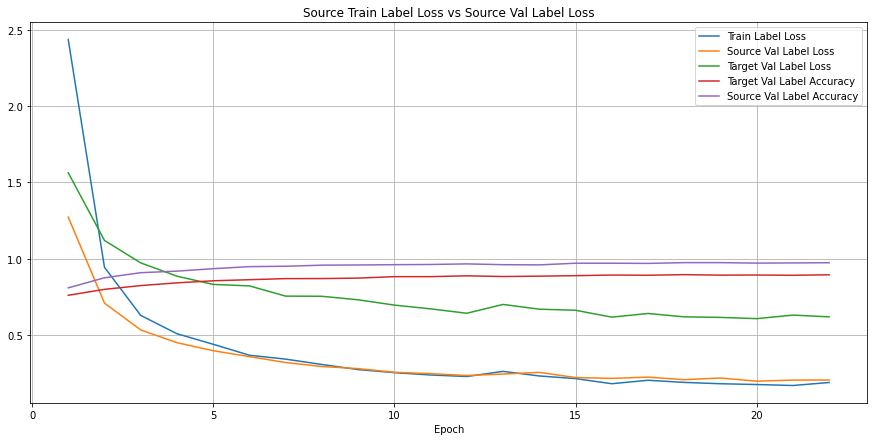

In [16]:
ax = get_loss_curve(experiment)
plt.show()

<AxesSubplot:title={'center':'Results'}>

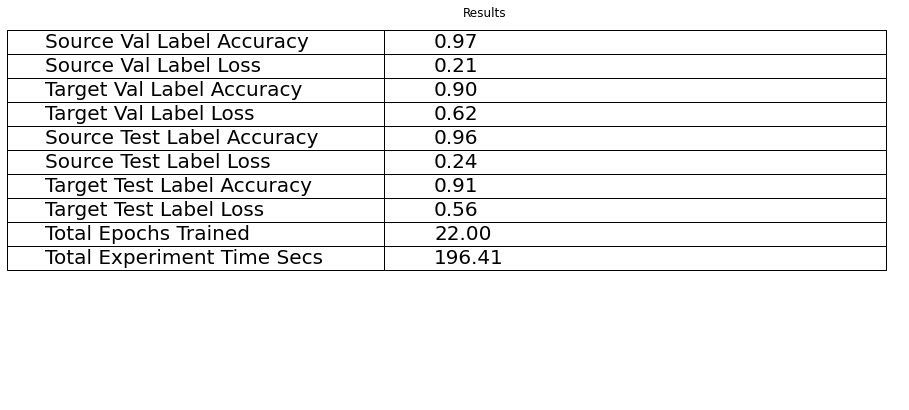

In [17]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Validation Accuracy'}, xlabel='domain'>

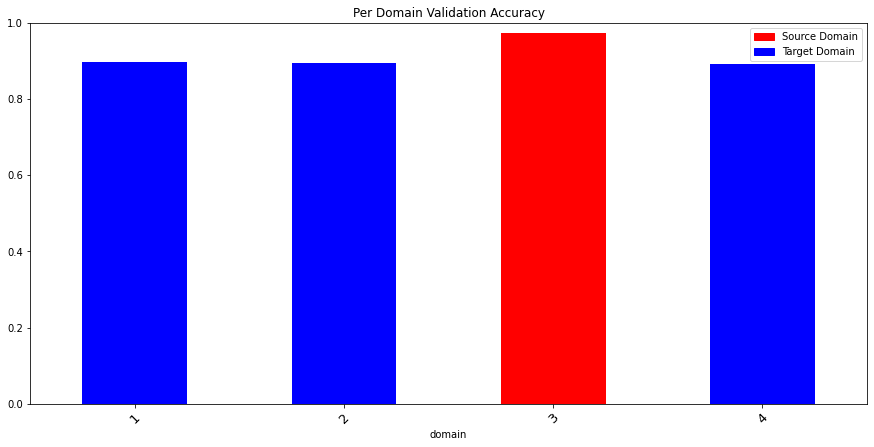

In [18]:
get_domain_accuracies(experiment)

In [19]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.9628205128205128 Target Test Label Accuracy: 0.9051282051282051
Source Val Label Accuracy: 0.9743589743589743 Target Val Label Accuracy: 0.8955128205128206


In [20]:
json.dumps(experiment)

'{"experiment_name": "tuned_1v2:wisig", "parameters": {"experiment_name": "tuned_1v2:wisig", "device": "cuda", "lr": 0.0001, "labels_source": ["1-10", "1-12", "1-14", "1-16", "1-18", "1-19", "1-8", "10-11", "10-17", "10-4", "10-7", "11-1", "11-10", "11-19", "11-20", "11-4", "11-7", "12-19", "12-20", "12-7", "13-14", "13-18", "13-19", "13-20", "13-3", "13-7", "14-10", "14-11", "14-12", "14-13", "14-14", "14-19", "14-20", "14-7", "14-8", "14-9", "15-1", "15-19", "15-6", "16-1", "16-16", "16-19", "16-20", "17-10", "17-11", "18-1", "18-10", "18-11", "18-12", "18-13", "18-14", "18-15", "18-16", "18-17", "18-19", "18-2", "18-20", "18-4", "18-5", "18-7", "18-8", "18-9", "19-1", "19-10", "19-11", "19-12", "19-13", "19-14", "19-15", "19-19", "19-2", "19-20", "19-3", "19-4", "19-6", "19-7", "19-8", "19-9", "2-1", "2-13", "2-15", "2-3", "2-4", "2-5", "2-6", "2-7", "2-8", "20-1", "20-12", "20-14", "20-15", "20-16", "20-18", "20-19", "20-20", "20-3", "20-4", "20-5", "20-7", "20-8", "3-1", "3-13", "